# Structural Estimation of the Buffer-Stock Model

## Setup

In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb
from scipy.optimize import minimize
from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Buffer-Stock Consumption-Saving Model

In [18]:
# load local model file and initialize model class
from BufferStockModel import BufferStockModelClass
model = BufferStockModelClass()

## Solve the model

In [19]:
model.solve()
par = model.par
sol = model.sol

**Last period, $t=T-1$**

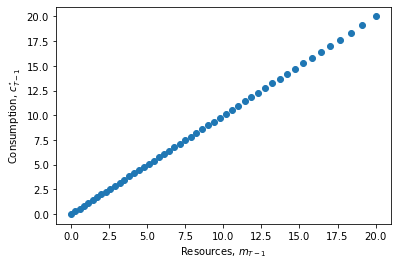

In [20]:
# last period consumption
t = par.T-1
fig, ax = plt.subplots()
ax.scatter(par.m_grid,sol.c[t,:])
ax.set(xlabel='Resources, $m_{T-1}$',ylabel='Consumption, $c_{T-1}^{\star}$');

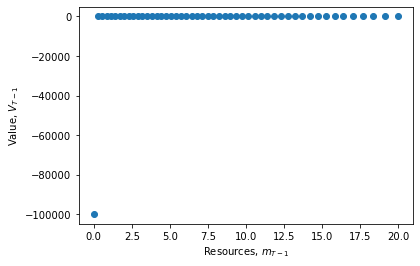

In [21]:
fig, ax = plt.subplots()
ax.scatter(par.m_grid,sol.V[t,:])
ax.set(xlabel='Resources, $m_{T-1}$',ylabel='Value, $V_{T-1}$');

**Question 1:** Why does the value function look like this? <br> \[*hint:* try plotting all but the first point in the grid.\]

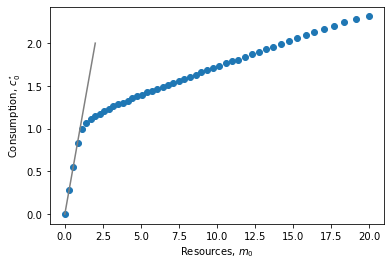

In [22]:
t = 0
fig, ax = plt.subplots()
ax.scatter(par.m_grid,sol.c[t,:])
ax.plot([0,2],[0,2],color='gray')
ax.set(xlabel='Resources, $m_{0}$',ylabel='Consumption, $c_{0}^{\star}$');

## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question

## Simulation

With the solution at hand we can now simulate `simN` synthetic individuals for `simT` periods. We do so by drawing transitory and permanent income shocks, `sim.xi` and `sim.psi`, from log normal distributions and initializing all state-variables in the first period and simulate forwards. 

We wish to simulate both normalized and un-normalized variables. We therefore have two state variables to initialize, wealth ($a_0$) and permanent income ($P_0$). We could also have initialized $m_0$ and $P_0$ but it feels more natural to initialize the level of wealth. 

We initilize all individuals with no wealth, `sim.a_init=np.zeros(par.simN)` and permanent income of 1, `sim.P_init=np.ones(par.simN)`. We can then construct $Y_{i,0}$ and $A_{i,0}$ and loop forward using the solution:
$$
\begin{align}
M_{i,t} &= (1+r)\cdot A_{i,t}  + Y_{i,t}\\
m_{i,t} &= M_{i,t}/P_{i,t} \\
c_{i,t} &= \check{c}_t^{\star}(m_{i,t}) \\
a_{i,t+1} &= m_{i,t} - c_{i,t} \\
P_{i,t+1} &= G\cdot P_{i,t} \cdot \psi_{i,t+1} \\
Y_{i,t+1} &= P_{i,t+1} \cdot \xi_{i,t+1} \\
\end{align}
$$

In [23]:
model.simulate()
sim = model.sim

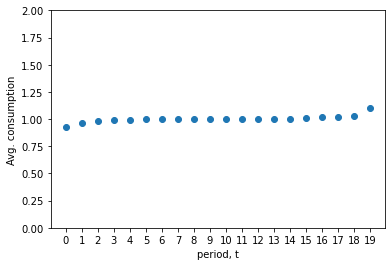

In [24]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.c,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. consumption',ylim=[0,2],xticks=range(par.simT));

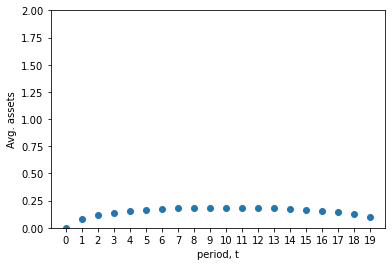

In [25]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.a,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. assets',ylim=[0,2],xticks=range(par.simT));

## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question
3. Simulate average wealth with a larger discount factor of, say, $\beta=0.99$. Does the savings behavior change in an intuitive way?

## Structural Estimation of $\theta=(\beta,\rho)$

In [26]:
def obj_func(theta,theta_names,mom_data,model,do_print=False):
    
    # printing
    if do_print: 
        print_str = ''
        for i,name in enumerate(theta_names):
            print_str += f'{name}={theta[i]:2.3f} '
        print(print_str)
            
    # calculate moments from simulation
    mom_sim = simulate_moments(theta,theta_names,model,do_print=False)
    
    # equal weighting
    obj = np.sum((mom_data - mom_sim)**2)
    
    # return objective and moments for plotting
    return obj

def simulate_moments(theta,theta_names,model,do_print=False):
        
    # update parameters
    for i,name in enumerate(theta_names):
        setattr(model.par,name,theta[i])
    
    # solve and simulate model with these parameters
    model.solve()
    model.simulate()
    
    # return moments from simulated data
    return moment_func(model.sim)

def moment_func(input_data):
    return np.mean(input_data.A,axis=0) # age profile of wealth

In [27]:
# simulate synthetic data with a known set of parameters. 
beta_true = 0.98
rho_true = 2.0

data_model = BufferStockModelClass(par={'beta':beta_true,'rho':rho_true})

data_model.solve()
data_model.simulate()

mom_data = moment_func(data_model.sim) # moments in data

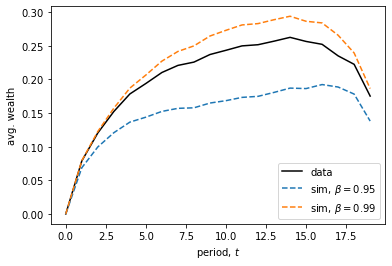

In [28]:
# Plot the different age-profiles for different values of, say, beta. the profiles are the 2.and 3. ourput from obj_func
mom_sim_95 = simulate_moments(np.array([0.95]),('beta',),model)
mom_sim_99 = simulate_moments(np.array([0.99]),('beta',),model)

fig, ax = plt.subplots()
ax.plot(range(par.simT),mom_data,label='data',color='black')
ax.plot(range(par.simT),mom_sim_95,linestyle='--',label=r'sim, $\beta=0.95$')
ax.plot(range(par.simT),mom_sim_99,linestyle='--',label=r'sim, $\beta=0.99$')
ax.set(xlabel='period, $t$',ylabel='avg. wealth')
ax.legend();

In [29]:
# evaluate objective function at truth.
# Because the seed is the same, the objective function is exactly zero.
theta_names = ('beta','rho')
theta_true = np.array([beta_true,rho_true])
obj_true = obj_func(theta_true,theta_names,mom_data,model)
obj_true

0.0

In [30]:
# plot objective function 
beta_grid = np.linspace(0.95,1.0,7)
rho_grid = np.linspace(1.5,2.5,7)

obj = np.nan + np.ones((beta_grid.size,rho_grid.size))
for ibeta,beta in enumerate(beta_grid):
    for irho,rho in enumerate(rho_grid):
        theta = [beta,rho]
        obj[ibeta,irho] = obj_func(theta,theta_names,mom_data,model)

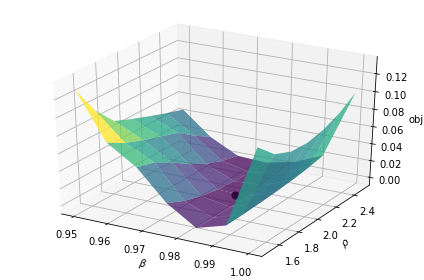

In [31]:
fig = plt.figure()
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(beta_grid, rho_grid,indexing='ij')
Z = obj

ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.scatter(beta_true,rho_true,obj_true,color='black',s=50)
ax.set(xlabel=r'$\beta$',ylabel=r'$\rho$',zlabel='obj');
plt.tight_layout()
plt.savefig('objective.pdf')  

In [32]:
# call numerical optimizer
objective = lambda theta: obj_func(theta,theta_names,mom_data,model,do_print=True)

theta_init = np.array([beta_true,rho_true]) * 0.98

res = minimize(objective,theta_init,method='nelder-mead')
res

beta=0.960 rho=1.960 
beta=1.008 rho=1.960 
beta=0.960 rho=2.058 
beta=0.912 rho=2.058 
beta=0.936 rho=2.033 
beta=0.984 rho=1.985 
beta=1.008 rho=1.960 
beta=0.984 rho=2.083 
beta=1.008 rho=2.009 
beta=0.972 rho=2.046 
beta=0.996 rho=2.021 
beta=0.978 rho=2.040 
beta=0.978 rho=1.942 
beta=0.972 rho=1.997 
beta=0.981 rho=1.988 
beta=0.981 rho=2.086 
beta=0.979 rho=1.978 
beta=0.976 rho=2.030 
beta=0.980 rho=1.998 
beta=0.981 rho=1.936 
beta=0.982 rho=1.957 
beta=0.980 rho=1.972 
beta=0.981 rho=1.962 
beta=0.980 rho=1.970 
beta=0.981 rho=1.964 
beta=0.980 rho=1.968 
beta=0.980 rho=2.030 
beta=0.980 rho=2.007 
beta=0.980 rho=1.977 
beta=0.980 rho=1.993 
beta=0.980 rho=2.031 
beta=0.980 rho=2.016 
beta=0.980 rho=2.002 
beta=0.980 rho=2.006 
beta=0.980 rho=2.028 
beta=0.980 rho=2.002 
beta=0.980 rho=2.012 
beta=0.980 rho=2.007 
beta=0.980 rho=1.993 
beta=0.980 rho=2.010 
beta=0.980 rho=1.999 
beta=0.980 rho=2.007 
beta=0.980 rho=2.002 
beta=0.980 rho=2.006 
beta=0.980 rho=2.000 
beta=0.980

 final_simplex: (array([[0.97999991, 2.000004  ],
       [0.97999948, 2.00005125],
       [0.97999894, 2.00008977]]), array([3.02523784e-13, 6.08842813e-13, 1.46473120e-12]))
           fun: 3.0252378424182687e-13
       message: 'Optimization terminated successfully.'
          nfev: 70
           nit: 37
        status: 0
       success: True
             x: array([0.97999991, 2.000004  ])